In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

Data Loading

In [2]:
prem_data = pd.read_excel('premiums_rest.xlsx')
prem_data.head()

,Unnamed: 0,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [3]:
prem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             29904 non-null  int64 
 1   Age                    29904 non-null  int64 
 2   Gender                 29904 non-null  object
 3   Region                 29904 non-null  object
 4   Marital_status         29904 non-null  object
 5   Number Of Dependants   29904 non-null  int64 
 6   BMI_Category           29904 non-null  object
 7   Smoking_Status         29895 non-null  object
 8   Employment_Status      29903 non-null  object
 9   Income_Level           29895 non-null  object
 10  Income_Lakhs           29904 non-null  int64 
 11  Medical History        29904 non-null  object
 12  Insurance_Plan         29904 non-null  object
 13  Annual_Premium_Amount  29904 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 3.2+ MB


In [4]:
prem_data.dtypes

Unnamed: 0                int64
Age                       int64
Gender                   object
Region                   object
Marital_status           object
Number Of Dependants      int64
BMI_Category             object
Smoking_Status           object
Employment_Status        object
Income_Level             object
Income_Lakhs              int64
Medical History          object
Insurance_Plan           object
Annual_Premium_Amount     int64
dtype: object

DATA CLEANING:

1. REMOVE TRIMSPACE/ HANDLE DATA TYPES
2. REMOVE DUPLICATES
3. HANDLE MISSING VALUES
4. HANDLE OUTLIERS

In [5]:
#convert the column names into snake case
prem_data.columns = prem_data.columns.str.replace(" ","_").str.lower()

In [6]:
all_features= prem_data.columns
all_features

Index(['unnamed:_0', 'age', 'gender', 'region', 'marital_status',
       'number_of_dependants', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'income_lakhs', 'medical_history',
       'insurance_plan', 'annual_premium_amount'],
      dtype='object')

## REMOVE TRIMSPACE/ HANDLE DATA TYPES

In [7]:
prem_data= prem_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/2006640918.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  prem_data= prem_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [8]:
prem_data.dtypes

unnamed:_0                int64
age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
dtype: object

In [9]:
prem_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29904 entries, 0 to 29903
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   unnamed:_0             29904 non-null  int64 
 1   age                    29904 non-null  int64 
 2   gender                 29904 non-null  object
 3   region                 29904 non-null  object
 4   marital_status         29904 non-null  object
 5   number_of_dependants   29904 non-null  int64 
 6   bmi_category           29904 non-null  object
 7   smoking_status         29895 non-null  object
 8   employment_status      29903 non-null  object
 9   income_level           29895 non-null  object
 10  income_lakhs           29904 non-null  int64 
 11  medical_history        29904 non-null  object
 12  insurance_plan         29904 non-null  object
 13  annual_premium_amount  29904 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 15.8 MB


In [10]:
#change the premium amount into float
prem_data['annual_premium_amount']= prem_data['annual_premium_amount'].astype('float64')

## 2. REMOVE DUPLICATES

In [11]:
prem_data[prem_data.duplicated()]

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount


No duplicates to drop

## 3. HANDLE MISSING VALUES

In [12]:
prem_data.isna().sum()

unnamed:_0               0
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

There are so many ways to impute the missing values.

1. Mean Imputation
2. Median Imputation
3. Frequency count Imputation
4. Mode Imputation
5. Random Imputation
6. Target Based Imputation

Let us try to use different imputations for three of them

In [13]:
#let us deep dive into each
prem_data['smoking_status'].value_counts()

smoking_status
No Smoking        13511
Regular           11195
Occasional         5177
Not Smoking           6
Does Not Smoke        3
Smoking=0             3
Name: count, dtype: int64

In [14]:
prem_data['smoking_status'].replace({"Smoking=0": "No Smoking",
    "Not Smoking":"No Smoking",
    "Does Not Smoke":"No Smoking"},inplace=True)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/2672277990.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prem_data['smoking_status'].replace({"Smoking=0": "No Smoking",


In [15]:
prem_data['smoking_status'].value_counts()

smoking_status
No Smoking    13523
Regular       11195
Occasional     5177
Name: count, dtype: int64

In [16]:
prem_data.groupby('bmi_category')['smoking_status'].value_counts(normalize=True)

bmi_category  smoking_status
Normal        No Smoking        0.470593
              Regular           0.359603
              Occasional        0.169803
Obesity       No Smoking        0.464583
              Regular           0.360285
              Occasional        0.175132
Overweight    Regular           0.415276
              No Smoking        0.408353
              Occasional        0.176370
Underweight   No Smoking        0.482246
              Regular           0.344461
              Occasional        0.173293
Name: proportion, dtype: float64

every bmi_category has more number of no smoking people , so there is no quite relationship so let us impute randomly

In [17]:
prem_data.notna().sum()

unnamed:_0               29904
age                      29904
gender                   29904
region                   29904
marital_status           29904
number_of_dependants     29904
bmi_category             29904
smoking_status           29895
employment_status        29903
income_level             29895
income_lakhs             29904
medical_history          29904
insurance_plan           29904
annual_premium_amount    29904
dtype: int64

In [18]:
def random_imputation( dataset, column):
    df= dataset
    col= column
    missing_values_indices= df[df[col].isna()].index  
    sample_values= df[df[col].notna()].sample(df[col].isna().sum(), replace= True, random_state= 30)
    sample_values.index= missing_values_indices
    df.loc[missing_values_indices,col]= sample_values
    return df[col]
    

In [19]:
prem_data['smoking_status']= random_imputation(prem_data,'smoking_status')

In [20]:
prem_data['smoking_status'].isna().sum()

0

In [21]:
prem_data['income_level'].value_counts()

income_level
<10L         10945
10L - 25L     8728
25L - 40L     6089
> 40L         4133
Name: count, dtype: int64

In [22]:
#let us see whether income level depend on employment_status
prem_data.groupby('employment_status')['income_level'].value_counts(normalize= True, ascending=False)

employment_status  income_level
Freelancer         <10L            0.375418
                   10L - 25L       0.256043
                   25L - 40L       0.243585
                   > 40L           0.124954
Salaried           <10L            0.438303
                   10L - 25L       0.307444
                   25L - 40L       0.128778
                   > 40L           0.125476
Self-Employed      10L - 25L       0.289817
                   25L - 40L       0.281976
                   <10L            0.266390
                   > 40L           0.161817
Name: proportion, dtype: float64

In [23]:
def impute_incomelevel(row):
    col1= row['income_lakhs']
    col2= row['income_level']
    print(col1, col2)
    if pd.isna(col2)== False:
        return col2
    elif pd.isna(col2):
            if col1< 10:
                return '<10L'
            elif col1>=10 & col1 < 25:
                return '10L-25L'
            elif col1>=25 & col1 < 40:
                return '25L - 40L'
            else:
                return '> 40L'
       

In [24]:
prem_data[prem_data['income_level'].isna()]

,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
4262,7094,33,Male,Southeast,Married,2,Normal,Regular,Self-Employed,NaN,7,High blood pressure,Silver,18335.0
9155,15395,27,Female,Northeast,Unmarried,2,Underweight,No Smoking,Freelancer,NaN,5,No Disease,Silver,14469.0
9198,15452,52,Male,Northeast,Married,3,Underweight,No Smoking,Freelancer,NaN,8,Thyroid,Silver,19535.0
10391,17438,40,Female,Northeast,Married,4,Obesity,Regular,Self-Employed,NaN,8,High blood pressure,Silver,22392.0
13435,22553,37,Female,Southeast,Unmarried,0,Underweight,Regular,Salaried,NaN,7,High blood pressure,Silver,18631.0
18166,30421,39,Female,Southeast,Unmarried,2,Obesity,No Smoking,NaN,NaN,8,High blood pressure,Silver,20114.0
26461,44177,40,Male,Southwest,Unmarried,0,Underweight,Occasional,Salaried,NaN,6,High blood pressure,Silver,16663.0
26978,45068,28,Female,Southwest,Married,3,Normal,No Smoking,Salaried,NaN,7,No Disease,Silver,13901.0
28490,47588,54,Male,Southwest,Married,4,Normal,Occasional,Self-Employed,NaN,2,Diabetes,Silver,19531.0


In [25]:
prem_data['income_level']= prem_data[['income_lakhs','income_level']].apply(impute_incomelevel, axis=1)

6 <10L
6 <10L
20 10L - 25L
77 > 40L
14 10L - 25L
4 <10L
46 > 40L
21 10L - 25L
21 10L - 25L
1 <10L
1 <10L
27 25L - 40L
20 10L - 25L
18 10L - 25L
7 <10L
37 25L - 40L
13 10L - 25L
83 > 40L
15 10L - 25L
19 10L - 25L
29 25L - 40L
4 <10L
27 25L - 40L
21 10L - 25L
20 10L - 25L
11 10L - 25L
14 10L - 25L
21 10L - 25L
8 <10L
23 10L - 25L
3 <10L
40 25L - 40L
84 > 40L
8 <10L
22 10L - 25L
9 <10L
1 <10L
71 > 40L
59 > 40L
97 > 40L
3 <10L
20 10L - 25L
30 25L - 40L
35 25L - 40L
37 25L - 40L
28 25L - 40L
28 25L - 40L
57 > 40L
5 <10L
1 <10L
4 <10L
5 <10L
5 <10L
9 <10L
25 10L - 25L
12 10L - 25L
22 10L - 25L
12 10L - 25L
19 10L - 25L
11 10L - 25L
15 10L - 25L
9 <10L
6 <10L
4 <10L
92 > 40L
25 25L - 40L
2 <10L
9 <10L
5 <10L
36 25L - 40L
24 10L - 25L
46 > 40L
12 10L - 25L
12 10L - 25L
34 25L - 40L
93 > 40L
78 > 40L
26 25L - 40L
3 <10L
68 > 40L
62 > 40L
31 25L - 40L
8 <10L
50 > 40L
4 <10L
23 10L - 25L
32 25L - 40L
1 <10L
9 <10L
27 25L - 40L
9 <10L
32 25L - 40L
26 25L - 40L
11 10L - 25L
22 10L - 25L
2 <10L
30 2

In [26]:
prem_data['income_level'].isna().sum()

0

In [27]:
prem_data['income_level'].value_counts()

income_level
<10L         10954
10L - 25L     8728
25L - 40L     6089
> 40L         4133
Name: count, dtype: int64

In [28]:
#smoking_status, income_level imputed successfully, let us impute employment_status now
prem_data['employment_status'].fillna(prem_data['employment_status'].mode().iloc[0], inplace=True)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/2641071521.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prem_data['employment_status'].fillna(prem_data['employment_status'].mode().iloc[0], inplace=True)


In [29]:
prem_data['employment_status'].mode()

0    Salaried
Name: employment_status, dtype: object

In [30]:
prem_data['employment_status'].isna().sum()

0

## 4. HANDLE OUTLIERS

In [31]:
#Before looking for outliers, let us visualize each column
numerical_columns= list(prem_data.select_dtypes(include=['int64','float64']).columns)
numerical_columns


['unnamed:_0',
 'age',
 'number_of_dependants',
 'income_lakhs',
 'annual_premium_amount']

In [32]:
categorical_columns= list(prem_data.select_dtypes(include=['object']).columns)
categorical_columns

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

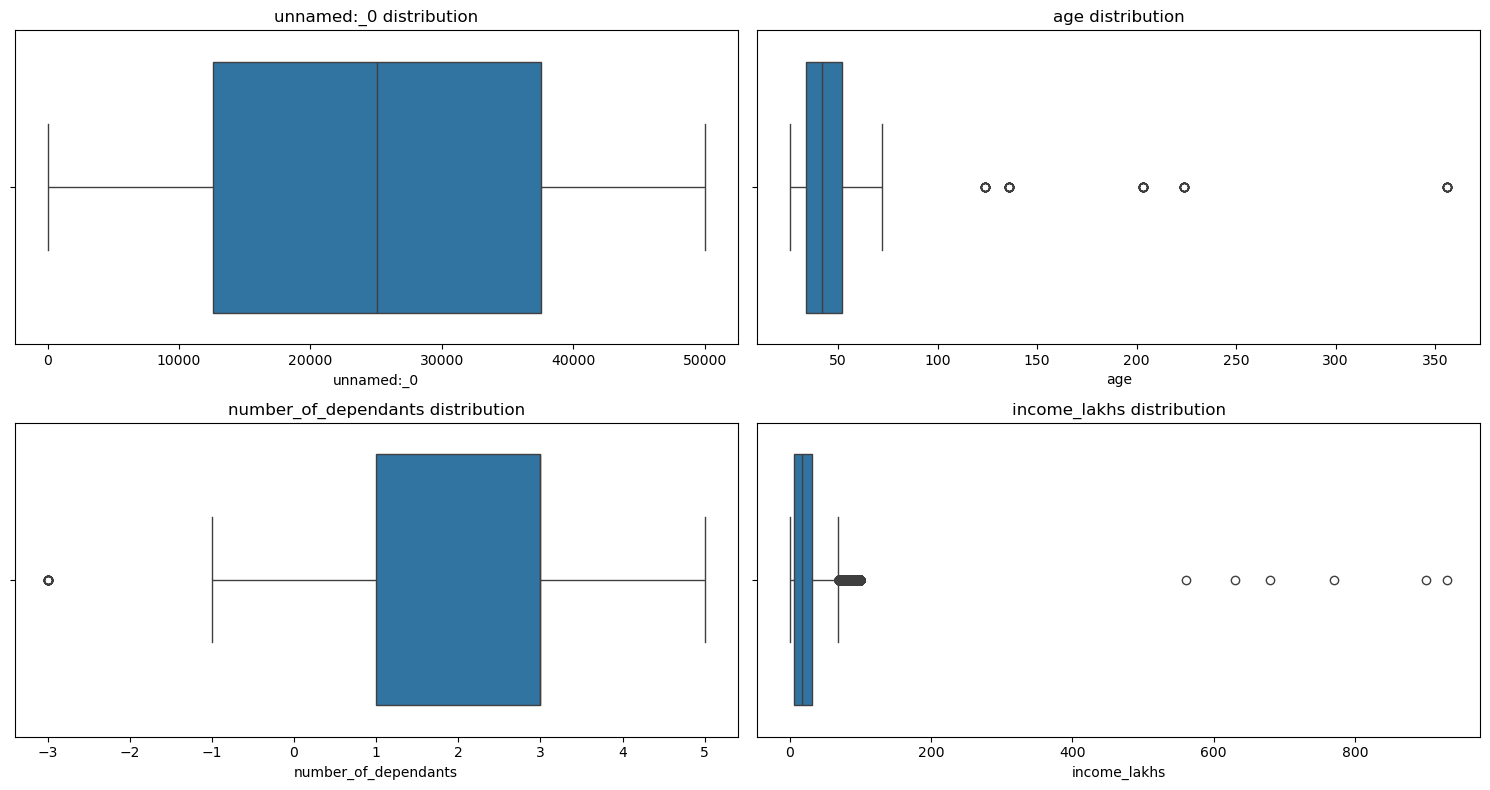

In [33]:
fig, axes= plt.subplots(2,2,figsize=(15,8))
axes= axes.flatten()
axes

for ax, col in zip(axes, numerical_columns):
    sns.boxplot(x= prem_data[col],ax = ax)
    ax.set_title(f'{col} distribution')
plt.tight_layout()
plt.show()

from the above figure age above 100 is not a valid so let us filter the records below 100

In [34]:
prem_data_filtered= prem_data[prem_data['age']<=100]

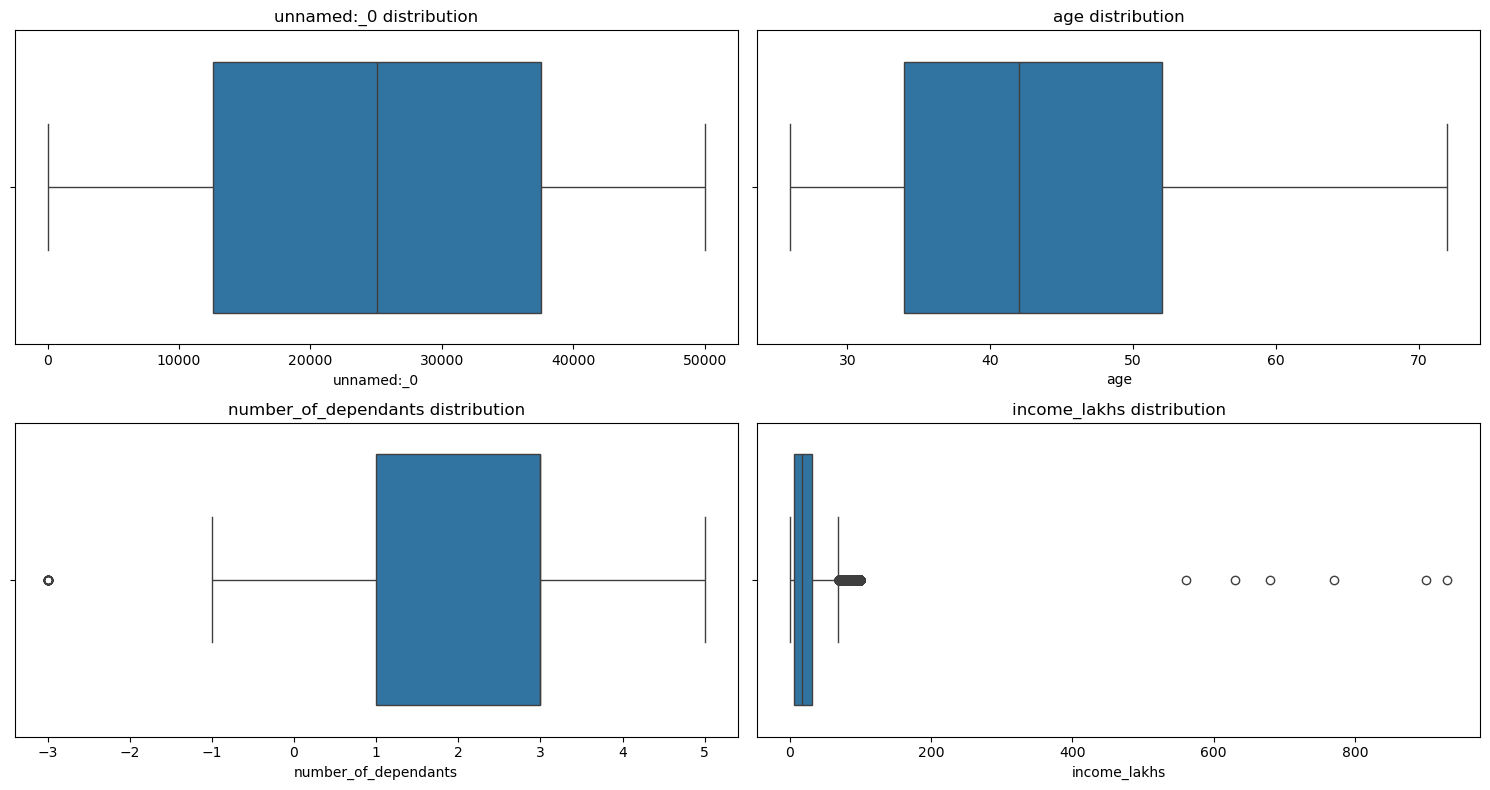

In [35]:
fig, axes= plt.subplots(2,2,figsize=(15,8))
axes= axes.flatten()
axes

for ax, col in zip(axes, numerical_columns):
    sns.boxplot(x= prem_data_filtered[col],ax = ax)
    ax.set_title(f'{col} distribution')
plt.tight_layout()
plt.show()

In [36]:
#Now let us find the IQR for income_lakhs
def quantile_calculation(col):
    Q1, Q3= col.quantile([0.25,0.75])
    IQR= Q3- Q1
    lower_bound = Q1- 1.5*IQR
    upper_bound= Q3+ 1.5*IQR
    return lower_bound,upper_bound
    

In [37]:
lf,hf=quantile_calculation(prem_data_filtered['income_lakhs'])
print(lf,hf)
prem_data_filtered[(prem_data_filtered['income_lakhs']<lf) | (prem_data_filtered['income_lakhs']> hf)].shape

-30.5 69.5


(2090, 14)

In [38]:
#as there are many records of outliers, after discusing with business team, decided to drop records at using quantile bound
threshold=prem_data_filtered['income_lakhs'].quantile(0.999) 
prem_data_filtered[prem_data_filtered['income_lakhs']>threshold].shape


(6, 14)

In [39]:
prem_data_filtered1=prem_data_filtered[prem_data_filtered['income_lakhs']<=threshold]

In [40]:
prem_data_filtered1.shape

(29840, 14)

## Univariate Analysis

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/2485165952.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation= 90)


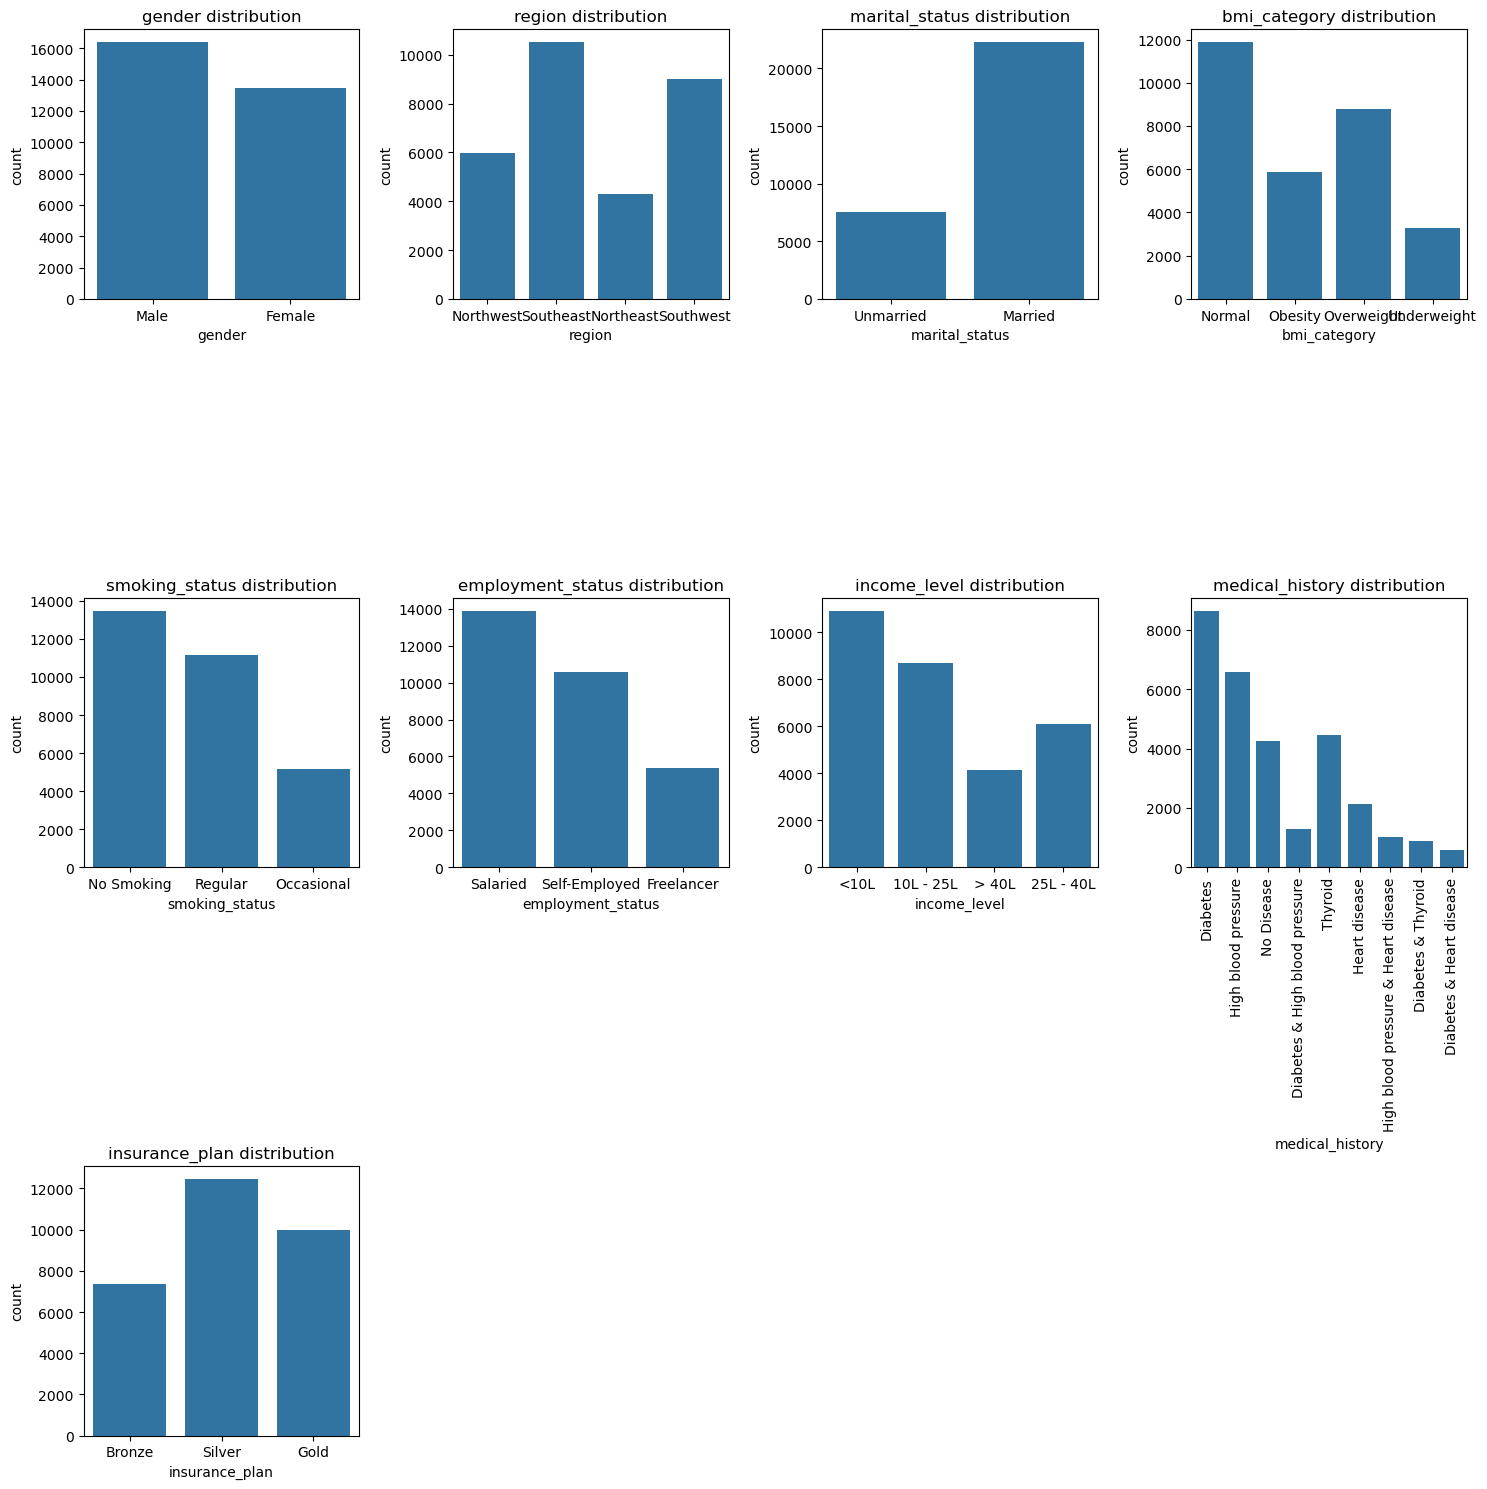

In [41]:
rows= 3
cols= (len(categorical_columns)//rows)+1
fig, axes= plt.subplots(rows,cols,figsize=(15,15))
axes= axes.flatten()
axes

for ax, col in zip(axes, categorical_columns):
    sns.countplot(x= prem_data_filtered1[col],ax = ax)
    ax.set_title(f'{col} distribution')
    if col== "medical_history":
        ax.set_xticklabels(ax.get_xticklabels(), rotation= 90)

for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i]) 
    
plt.tight_layout()
plt.show()

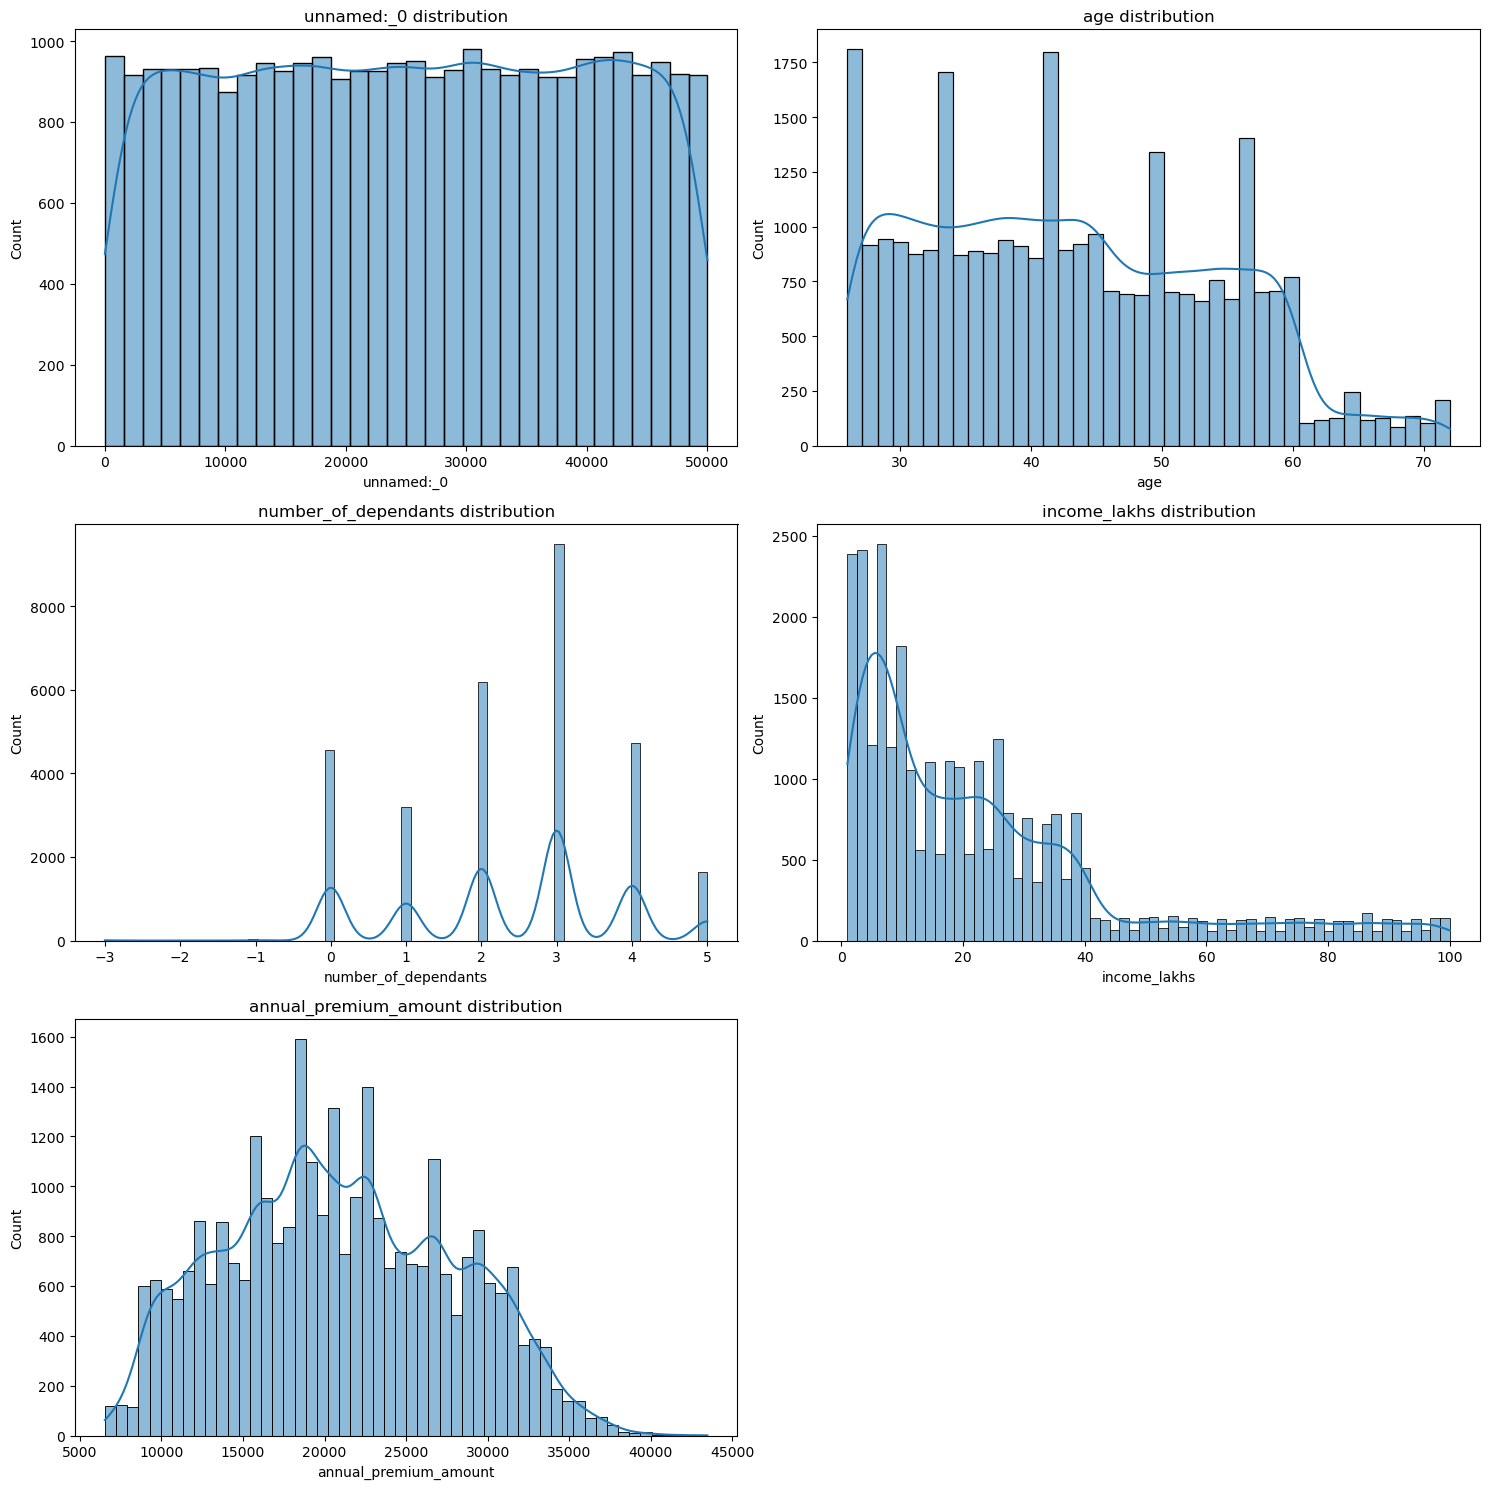

In [42]:
rows= 3
cols= (len(numerical_columns)//rows)+1
fig, axes= plt.subplots(rows,cols,figsize=(15,15))
axes= axes.flatten()
axes

for ax, col in zip(axes, numerical_columns):
    sns.histplot(x= prem_data_filtered1[col],ax = ax,kde=True)
    ax.set_title(f'{col} distribution')


for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i]) 
    
plt.tight_layout()
plt.show()

As number_of_dependants are less than 0, make them absolute values.

In [43]:
prem_data_filtered1['number_of_dependants']=prem_data_filtered1['number_of_dependants'].abs()

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/2138320173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['number_of_dependants']=prem_data_filtered1['number_of_dependants'].abs()


## Bi Variate Analysis

In [44]:
crosstab=pd.crosstab(prem_data_filtered1['marital_status'],prem_data_filtered1['smoking_status'])

<Axes: xlabel='marital_status'>

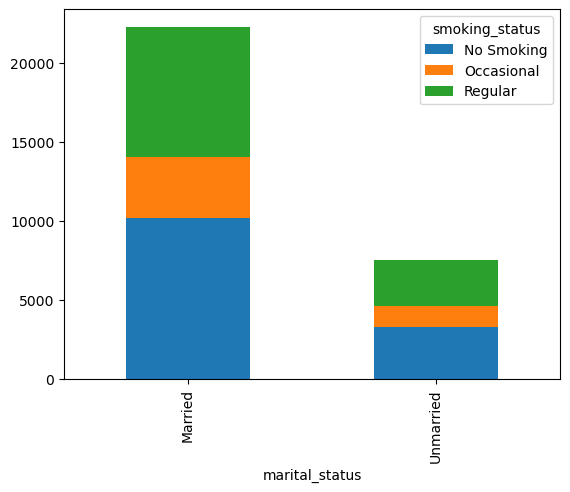

In [45]:
crosstab.plot(kind="bar",stacked=True)

<Axes: xlabel='smoking_status', ylabel='marital_status'>

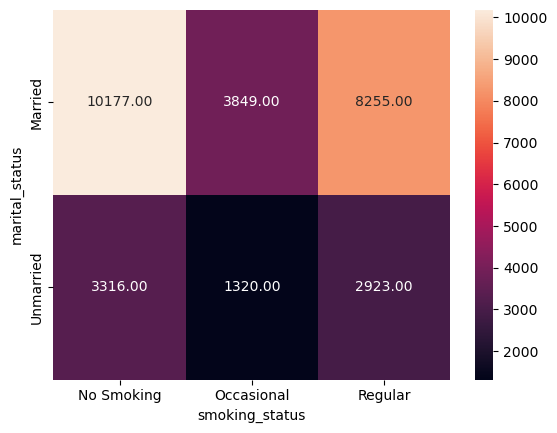

In [46]:
sns.heatmap(crosstab, annot=True,fmt=".2f")

In [47]:
numerical_columns

['unnamed:_0',
 'age',
 'number_of_dependants',
 'income_lakhs',
 'annual_premium_amount']

<Axes: xlabel='number_of_dependants', ylabel='age'>

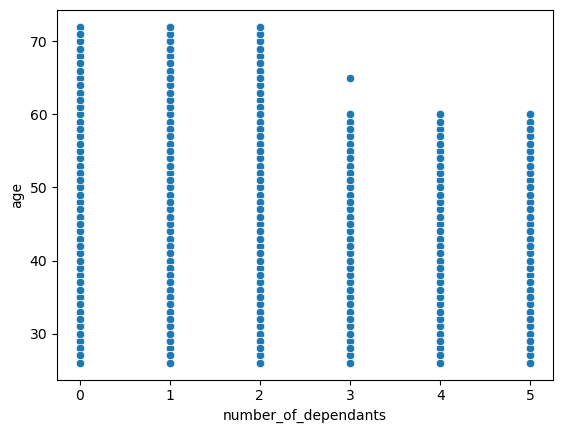

In [48]:
sns.scatterplot(y='age',x='number_of_dependants',data=prem_data_filtered1)

## Encode the categorical columns

In [49]:
categorical_columns

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [50]:
prem_data_filtered1['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [51]:
risk_score={
"diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0 
}


In [52]:
prem_data_filtered1[['dis1', 
                     'dis2']]= prem_data_filtered1['medical_history'].str.split('&',expand=True).apply(lambda x: x.str.lower())


/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/4268426606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1[['dis1',
/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/4268426606.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1[['dis1',


In [53]:
prem_data_filtered1['dis1'].fillna('none', inplace=True)
prem_data_filtered1['dis2'].fillna('none', inplace=True)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/50144401.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prem_data_filtered1['dis1'].fillna('none', inplace=True)
/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/50144401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['dis1'].fillna('

In [54]:
prem_data_filtered1['risk_score']= 0

def calculate_total_risk_score(row):
    disease1= row['dis1'].strip()
    disease2= row['dis2'].strip()
    score1= risk_score[disease1]
    score2= risk_score[disease2]
    return score1+ score2
    


/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/1736859144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['risk_score']= 0


In [55]:
prem_data_filtered1['risk_score']=prem_data_filtered1[['dis1','dis2']].apply(calculate_total_risk_score, axis=1)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/3616989725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['risk_score']=prem_data_filtered1[['dis1','dis2']].apply(calculate_total_risk_score, axis=1)


In [56]:
max_score= prem_data_filtered1['risk_score'].max()
min_score= prem_data_filtered1['risk_score'].min()
prem_data_filtered1['normalized_score']= (prem_data_filtered1['risk_score']- min_score)/(max_score-min_score)
prem_data_filtered1.head()

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/20049080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['normalized_score']= (prem_data_filtered1['risk_score']- min_score)/(max_score-min_score)


,unnamed:_0,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,dis1,dis2,risk_score,normalized_score
0,0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053.0,diabetes,none,6,0.428571
1,1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339.0,diabetes,none,6,0.428571
2,2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164.0,high blood pressure,none,6,0.428571
3,3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303.0,no disease,none,0,0.000000
4,5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610.0,diabetes,none,6,0.428571


In [57]:
prem_data_filtered1.drop(columns= ['dis1','dis2','risk_score','medical_history'],inplace=True)

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/534884300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1.drop(columns= ['dis1','dis2','risk_score','medical_history'],inplace=True)


In [58]:
categorical_columns=list(prem_data_filtered1.select_dtypes(include='object').columns)
categorical_columns

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'insurance_plan']

In [59]:
prem_data_filtered1['income_level'].value_counts()

income_level
<10L         10932
10L - 25L     8708
25L - 40L     6079
> 40L         4121
Name: count, dtype: int64

In [60]:
prem_data_filtered1['income_level']= prem_data_filtered1['income_level'].map({'<10L':1,'10L - 25L': 2, '25L - 40L':3, '> 40L':4})
prem_data_filtered1['insurance_plan']= prem_data_filtered1['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/2861020348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['income_level']= prem_data_filtered1['income_level'].map({'<10L':1,'10L - 25L': 2, '25L - 40L':3, '> 40L':4})
/var/folders/0n/xvnlc6tj4b912wtm7gxtwn680000gn/T/ipykernel_11230/2861020348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data_filtered1['insurance_plan']= prem_data_filtered1['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})


In [61]:
#for all the nominal_columns do one hot encoding
nominal_columns= ['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status']
prem_data_filtered2= pd.get_dummies(prem_data_filtered1, columns=nominal_columns, drop_first= True,dtype=int)
prem_data_filtered2.head()

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,26,0,1,6,1,9053.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,29,2,1,6,1,16339.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,2,49,2,2,20,2,18164.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,3,30,3,4,77,3,20303.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,5,56,3,2,14,1,15610.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


## Feature Scaling/Selection

In [62]:
prem_data_filtered2.columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_level',
       'income_lakhs', 'insurance_plan', 'annual_premium_amount',
       'normalized_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

<Axes: >

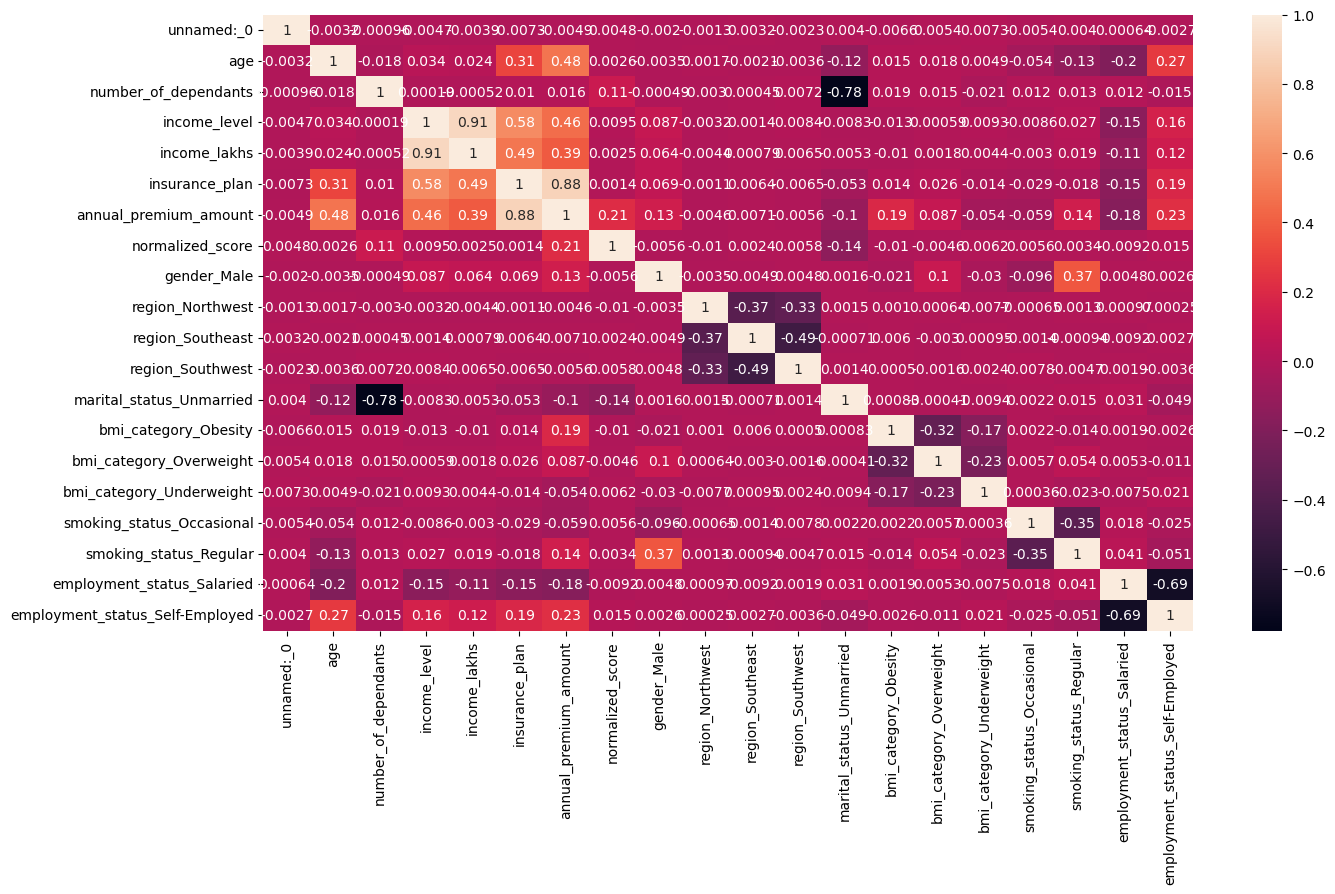

In [63]:
correlation_matrix= prem_data_filtered2.corr()
plt.figure(figsize=(15,8))
sns.heatmap(correlation_matrix, annot= True)

In [64]:
X= prem_data_filtered2.drop(columns='annual_premium_amount')
y= prem_data_filtered2['annual_premium_amount']

In [65]:
X.columns

Index(['unnamed:_0', 'age', 'number_of_dependants', 'income_level',
       'income_lakhs', 'insurance_plan', 'normalized_score', 'gender_Male',
       'region_Northwest', 'region_Southeast', 'region_Southwest',
       'marital_status_Unmarried', 'bmi_category_Obesity',
       'bmi_category_Overweight', 'bmi_category_Underweight',
       'smoking_status_Occasional', 'smoking_status_Regular',
       'employment_status_Salaried', 'employment_status_Self-Employed'],
      dtype='object')

In [66]:
columns_to_scale=['age','number_of_dependants','income_level','income_lakhs','insurance_plan']


In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
scaler= MinMaxScaler()
X[columns_to_scale]= scaler.fit_transform(X[columns_to_scale])
X.describe()

,unnamed:_0,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000,29840.000000
mean,25028.941019,0.371642,0.477587,0.371191,0.224488,0.544186,0.426398,0.549095,0.200603,0.352614,0.302111,0.253318,0.196816,0.294940,0.110221,0.173224,0.374598,0.466119,0.354256
std,14430.300800,0.240067,0.284118,0.351129,0.226800,0.378951,0.240106,0.497592,0.400458,0.477792,0.459181,0.434919,0.397599,0.456023,0.313170,0.378447,0.484027,0.498859,0.478295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12608.750000,0.173913,0.200000,0.000000,0.060606,0.500000,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25066.500000,0.347826,0.600000,0.333333,0.161616,0.500000,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37563.250000,0.565217,0.600000,0.666667,0.313131,1.000000,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,49999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
#let us check for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df= pd.DataFrame()
    vif_df['Column']= data.columns
    vif_df['VIF']= [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [70]:
vif_df=calculate_vif(X)
vif_df.sort_values('VIF', ascending=False)

,Column,VIF
3,income_level,13.887510
4,income_lakhs,11.186411
2,number_of_dependants,6.572626
5,insurance_plan,5.273520
1,age,3.956829
6,normalized_score,3.848043
0,unnamed:_0,3.708207
17,employment_status_Salaried,3.208946
9,region_Southeast,3.015125
18,employment_status_Self-Employed,2.888013


As income_level and income_lakhs both explain the same thing, the variance_inflation_factor is high, let us drop one

In [71]:
calculate_vif(X.drop(columns='income_level'))

,Column,VIF
0,unnamed:_0,3.708148
1,age,3.897924
2,number_of_dependants,6.571987
3,income_lakhs,2.679530
4,insurance_plan,4.577552
5,normalized_score,3.845800
6,gender_Male,2.592596
7,region_Northwest,2.142180
8,region_Southeast,3.014239
9,region_Southwest,2.736988


Now everything looks good

In [72]:
X_reduced= X.drop(columns='income_level')
X_reduced.head()

,unnamed:_0,age,number_of_dependants,income_lakhs,insurance_plan,normalized_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,5,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


## Model Building

In [73]:
X_train, X_test, y_train, y_test= train_test_split(X_reduced, y, test_size=0.2, random_state=30)

In [74]:
print("X_train shape",X_train.shape)
print("X_test shape",X_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

X_train shape (23872, 18)
X_test shape (5968, 18)
y_train shape (23872,)
y_test shape (5968,)


## Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression

In [76]:
linear_model= LinearRegression()
linear_model.fit(X_train, y_train)

#check for scores (R2)
test_score= linear_model.score(X_test, y_test)
train_score= linear_model.score(X_train, y_train)
print(train_score,test_score)

0.9536561063552644 0.9529818545750932


In [77]:
#check for mse and rmse

y_pred= linear_model.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mse)
print("MSE for linear Regression", mse, "RMSE for linear regression", rmse)

MSE for linear Regression 2261976.6488835826 RMSE for linear regression 1503.9869177900393


## Random Forest Regressor

In [78]:
from sklearn.ensemble import RandomForestRegressor

In [79]:
rf_model= RandomForestRegressor(n_estimators=100, criterion= 'squared_error',max_depth =4,random_state=30)
rf_model.fit(X_train, y_train)

rf_test_score= rf_model.score(X_test, y_test)
rf_train_score= rf_model.score(X_train, y_train)
print(rf_test_score,rf_train_score)

0.909213279551982 0.9107856634458847


In [80]:
#check for mse and rmse
rf_preds= rf_model.predict(X_test)
rf_mse= mean_squared_error(y_test,rf_preds)
rf_rmse= np.sqrt(rf_mse)
print("MSE for Random Forest Regressor", rf_mse, "RMSE for Random Forest Regressor", rf_rmse)

MSE for Random Forest Regressor 4367621.049837391 RMSE for Random Forest Regressor 2089.88541548033


## XGBoost Regressor

In [81]:
from xgboost import XGBRegressor

In [82]:
xgb_model= XGBRegressor(n_estimators= 50, max_depth= 5)
xgb_model.fit(X_train, y_train)


xgb_test_score= xgb_model.score(X_test, y_test)
xgb_train_score= xgb_model.score(X_train, y_train)
print(xgb_test_score,xgb_train_score)

0.9980687514454342 0.9982159907278191


In [83]:
xgb_preds= xgb_model.predict(X_test)
xgb_mse= mean_squared_error(y_test, xgb_preds)
xgb_rmse= np.sqrt(xgb_mse)
print("MSE for XGBoost Regressor", xgb_mse, "RMSE for XGBoost Regressor", xgb_rmse)

MSE for XGBoost Regressor 92909.64358845005 RMSE for XGBoost Regressor 304.8108324657279


Out of three models XGBoost performed better, let us do hyper parameter tuning for the model

## Hyper Paramter tuning

In [84]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}


In [85]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,              # Try 50 different combinations
    scoring='neg_mean_squared_error',
    cv=5,                   # 5-fold cross-validation
    verbose=2,
    random_state=30,
    n_jobs=-1               # Use all available cores
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          multi_strategy=None, n_estimators=50,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 8, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=30, scoring='neg_mean_squared_error',
                   verbose=2)

In [86]:
best_params=random_search.best_params_
best_params

{'subsample': 0.8,
 'reg_lambda': 1.5,
 'reg_alpha': 0.1,
 'n_estimators': 300,
 'max_depth': 4,
 'learning_rate': 0.05,
 'colsample_bytree': 1.0}

In [87]:
#now train the model based on this params
xgb_model_opt= XGBRegressor(n_estimators= best_params['n_estimators'], max_depth= best_params['max_depth'],
                            reg_lambda= best_params['reg_lambda'],
                           reg_alpha=best_params['reg_alpha'],
                           learning_rate=best_params['learning_rate'],
                           colsample_bytree=best_params['colsample_bytree'])
xgb_model_opt.fit(X_train, y_train)


xgb_test_score_opt= xgb_model_opt.score(X_test, y_test)
xgb_train_score_opt= xgb_model_opt.score(X_train, y_train)
print(xgb_test_score_opt,xgb_train_score_opt)

0.998151198356121 0.9981734929781516


In [88]:
xgb_preds_opt= xgb_model_opt.predict(X_test)
xgb_mse_opt= mean_squared_error(y_test, xgb_preds_opt)
xgb_rmse_opt= np.sqrt(xgb_mse_opt)
print("MSE for XGBoost Regressor", xgb_mse_opt, "RMSE for XGBoost Regressor", xgb_rmse_opt)

MSE for XGBoost Regressor 88943.23902143067 RMSE for XGBoost Regressor 298.2335310145904


In [89]:
residuals_df=pd.DataFrame({
  'actual': y_test,
'pred': xgb_preds_opt,
'residual': xgb_preds_opt-y_test,
'percentage': ((xgb_preds_opt-y_test)/(y_test))*100
})
residuals_df

,actual,pred,residual,percentage
2210,26702.0,27126.789062,424.789062,1.590851
23487,15135.0,15617.793945,482.793945,3.189917
20272,20103.0,20620.648438,517.648438,2.574981
17910,21923.0,22049.027344,126.027344,0.574864
26975,22378.0,22555.404297,177.404297,0.792762
...,...,...,...,...
6529,21160.0,21635.705078,475.705078,2.248134
14213,32202.0,32522.964844,320.964844,0.996723
20493,13699.0,14091.001953,392.001953,2.861537
28876,18845.0,18673.148438,-171.851562,-0.911921


In [90]:
threshold_res= 10
extreme_residuals=residuals_df[residuals_df['percentage']>threshold_res]
extreme_residuals.shape

(0, 4)

In [91]:
print(extreme_residuals.shape[0]/X_test.shape[0])


0.0


This model is perfect for people elder than 25.